In [572]:
import numpy as np
import matplotlib.pyplot as plt
import os
import ManualPCAMI as mp
from itertools import combinations
from scipy.stats import ttest_rel
import matplotlib.ticker as ticker
import glob

In [327]:
procesadas = "D:\\Figure 4 Fix"

In [328]:
def clusters_match(labels_UMAP, labels_PCA):
    unique_labels_UMAP = np.unique(labels_UMAP)
    noise_UMAP = np.where(unique_labels_UMAP==-1)[0]
    if len(noise_UMAP) == 1:
        unique_labels_UMAP = np.delete(unique_labels_UMAP, noise_UMAP[0])
    corrected_UMAP_labels = np.arange(len(unique_labels_UMAP))
    unique_labels_PCA = np.unique(labels_PCA)
    noise_PCA = np.where(unique_labels_PCA==-1)[0]
    if len(noise_PCA) == 1:
        unique_labels_PCA = np.delete(unique_labels_PCA, noise_PCA[0])
    corrected_PCA_labels = np.arange(len(unique_labels_PCA))
    ps = [list(c) for r in range(1, len(unique_labels_UMAP)+1) for c in combinations(unique_labels_UMAP, r)] #Power set
    corrected_ps = [list(c) for r in range(1, len(corrected_UMAP_labels)+1) for c in combinations(corrected_UMAP_labels, r)]
    optimalF1scorexneuron = []
    for idx, i in enumerate(unique_labels_PCA):
        F1scorexcombination = []
        idxs_ref = np.where(labels_PCA==i)[0]
        for subset in ps:
            idxs_comp = np.where(np.isin(labels_UMAP, subset))[0]
            TP = len(np.intersect1d(idxs_ref, idxs_comp))
            FP = len(np.setdiff1d(idxs_comp, idxs_ref))
            FN = len(np.setdiff1d(idxs_ref, idxs_comp))
            precision = TP / (TP + FP)
            recall = TP / (TP + FN)
            if recall + precision > 0:
                F1scorexcombination.append((2*precision*recall)/(precision + recall))
            else: 
                F1scorexcombination.append(0)
        optimalF1scorexneuron.append([corrected_PCA_labels[idx], corrected_ps[np.argmax(F1scorexcombination)]])
    return optimalF1scorexneuron

In [329]:
def ntdd(ensayos, ventana=0.2, paso=0.02, tiempo_i=-2, tiempo_f=4, z="n", m=0, d=1):
    """
    Función realizada por Daniel Suárez
    Esta función muestra la gráfica de la tasa de disparo de un conjunto de ensayos de un archivo según indique el usuario.

    La función tiene 9 parámetros, 2 opcionales:
    1. ensayos: Es el archivo que contiene los ensayos con los tiempos en los que se dieron los registros de los potenciales de acción.
    2. ventana: Es la longitud (en segundos) de una ventana causal y cuadrada sobre la cual se contarán los registros.
    3. paso: Es el tiempo (en segundos) por el cual se desplazará nuestra ventana.
    4. color: Es el color de la gráfica.
    5. nombre: Nombre del archivo que irá en la etiqueta de la gráfica
    6. tiempo_i (opcional): Es el tiempo (en segundos) a partir del cual se comienzan a realizar los registros.
    7. tiempo_f (opcional): Es el tiempo (en segundos) final considerado para tomar los registros.
    """
    frecuencias_de_disparo=[[] for i in range(len(ensayos))] #Generamos una lista de listas vacías del tamaño del número de ensayos que abarquemos
    for i in range(len(ensayos)): #Iteramos sobre el número de ensayos
        ensayo=ensayos[i]
        limite_i=tiempo_i #Definimos el limite inicial del primer intervalo
        limite_f=tiempo_i+ventana #Definimos el límite final del primer intervalo
        while limite_f<=tiempo_f: #Ciclamos mientras el límite final de los intervalos no alcancé el límite final de tiempo del documento
            potenciales=np.array(ensayo>=limite_i) & np.array(ensayo<=limite_f) #Contamos el número de potenciales según cumplan la condición de encontrarse entre los valores límites del intervalo
            frecuencias_de_disparo[i].append(len(ensayo[potenciales])) #Añadimos a una de nuestras listas generadas previamente el valor de potenciales contados por intervalo
            limite_i+=paso #Añadimos a ambos límites el valor del paso
            limite_f+=paso
    tdd=np.array(frecuencias_de_disparo)/ventana
    t=np.linspace(tiempo_i+ventana, tiempo_f+paso, len(tdd[0]))
    if z=="e":
        tdd=tdd*ventana
        return tdd, t
    if z=="t":
        z=(tdd-np.mean(tdd))/np.std(tdd)
        return z, t
    elif z=="g":
        return np.mean(tdd), np.std(tdd)
    elif z=="b":
        z=(tdd-m)/d
        return z, t
    elif z=="v" or z=="c": #En el caso de escoger "c" el usuario debe considerar separar por clases a la hora de llamar la función
        z=(tdd-np.mean(tdd, axis=0))/np.std(tdd, axis=0)
        return z, t
    else:
        return tdd, t

In [330]:
def ajustar_indices(c, eliminados):
    c = np.array(c)
    eliminados = np.sort(np.array(eliminados))
    c = np.setdiff1d(c, eliminados, assume_unique=True)
    for i, e in enumerate(eliminados):
        c[c > e] -= 1
    return c

In [331]:
def indices_extra(a, b):
    i = j = 0
    faltantes = []

    while j < len(b):
        if i < len(a) and a[i] == b[j]:
            i += 1
            j += 1
        else:
            faltantes.append(j)
            j += 1
    return np.array(faltantes)

In [332]:
def infmutua(datos):
    im=0
    for i in range(len(datos)-1):
        ie=0
        for j in range(len(datos[0])):
            if datos[i][j]==0:
                ir=0
                ie+=ir
            else:
                ir=(1/(len(datos)-1))*(datos[i][j])*np.log2(((datos[i][j])/(datos[-1][j])))
                ie+=ir
        im+=ie
    return im

In [333]:
def cumulative(datos_PCA, datos_UMAP, color, color2, bins=15, logarithmic=False, download=False):
    datos = np.concatenate((datos_PCA, datos_UMAP))
    bns=np.linspace(min(datos), max(datos), int(bins)+1)
    y_PCA = np.histogram(datos_PCA, bins=bns)
    y_UMAP = np.histogram(datos_UMAP, bins=bns)
    medios = (bns[1:] + bns[:-1]) / 2
    plt.plot(medios, np.cumsum(y_UMAP[0]/len(datos_UMAP)), label="UMAP", color=color2)
    plt.plot(medios, np.cumsum(y_PCA[0]/len(datos_PCA)), label="PCA", color=color)
    plt.legend(frameon=False, labelcolor=[color2, color], fontsize=14)
    minimum_prob = np.min(np.concatenate((np.cumsum(y_UMAP[0]/len(datos_UMAP)), np.cumsum(y_PCA[0]/len(datos_PCA)))))
    #plt.yticks(y_ticks, fontsize=14)      
    if logarithmic==True:
        plt.xscale("log")
        plt.yscale("log")
    x_min, x_max = min(medios), 50
    plt.xticks([5, 50], ["5", "50"], fontsize=14)
    y_start = np.min(np.concatenate((np.cumsum(y_UMAP[0]/len(datos_UMAP)), np.cumsum(y_PCA[0]/len(datos_PCA)))))
    ax = plt.gca()
    ax.set_yticks([0.2, 1.0])
    ax.tick_params(axis='y', labelsize=14)
    ax.set_yticklabels(["0.2", "1"])
    ax.yaxis.set_major_locator(ticker.FixedLocator([0.2, 1.0]))
    ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(1, 10)*0.1))
    ax.yaxis.set_minor_formatter(ticker.NullFormatter())
    plt.xlim(x_min, x_max)
    plt.ylim(y_start, 1)
    plt.ylabel("cumulative prob.", fontsize=14)
    plt.xlabel("average FR[hz]", fontsize=14)
    if download==True:
        plt.savefig(f"Cumulative {color2}.svg")
    plt.show()

# DPC

### Firing rate (UMAP)

In [194]:
base_DPC = "D:\\Figure 4 Fix\\Processed DPC\\Processed" 

In [195]:
sesiones_DPC = os.listdir(os.path.join(procesadas, "Processed DPC", "Processed"))
psico_DPC=[]
clasesxneurona_DPC=[]
aciertosxneurona_DPC=[]
neuronas_DPC=[]
neu_x_sesion_DPC=np.zeros(len(sesiones_DPC)+1)

In [196]:
# Erase this!
base_DPC = "D:\\Figure 4 Fix\\Processed DPC\\Processed" 
for i in sesiones_DPC:
    sesion = os.path.join(base_DPC, i)
    electrodos = os.listdir(sesion)[:-1]
    for j in electrodos:
        electrodo = os.path.join(sesion, j, "Sorting PCA")
        for filename in os.listdir(electrodo):
            file_path = os.path.join(electrodo, filename)
            if os.path.isfile(file_path):
                os.remove(file_path)

In [197]:
nums=[]
nombres_neuronas=[]
neuxsesxelec_DPC = []
for total, i in enumerate(sesiones_DPC): 
    sesion = os.path.join(procesadas, "Processed DPC", "Processed", i)
    electrodos = os.listdir(sesion)[:-1]
    psico=np.loadtxt(os.path.join(sesion, os.listdir(sesion)[-1]), delimiter=",", skiprows=1, usecols=(1, 4, 26))
    psico_DPC.append(psico)
    neu_x_elec = np.zeros(len(electrodos))
    for num_elec, j in enumerate(electrodos):
        electrodo = os.path.join(sesion, j, "sorted_neurons")
        if os.path.exists(electrodo)==True:
            archivos_neuronas = [os.path.basename(f) for f in glob.glob(os.path.join(electrodo, "ne*.csv"))]
            neu_x_elec[num_elec] = len(archivos_neuronas)
            for k in archivos_neuronas:
                conteo_orden=0
                en_es_cl=np.loadtxt(os.path.join(electrodo, k), delimiter=",", skiprows=1)
                ensayos=np.array(np.unique(en_es_cl[:, 0]), dtype=np.int64)
                ensayos_limpios=[]
                clases=np.zeros(len(ensayos))
                aciertos=np.zeros(len(ensayos))
                numero_en=len(ensayos)
                nums.append(numero_en)
                nombres_neuronas.append([electrodo, k])
                for idx, l in enumerate(ensayos):
                    conteo_orden+=1
                    if l==conteo_orden:
                        espigas=en_es_cl[np.where(en_es_cl[:, 0]==l)].T
                        ensayo=espigas[1, :]
                    if len(ensayo)!=0:
                        clases[idx]=psico[l-1, 0]
                        aciertos[idx]=psico[l-1, 1]
                        ensayos_limpios.append(ensayo)
                    else:
                        ensayos_limpios.append(np.array([-7]))
                neuronas_DPC.append(ensayos_limpios)
                clasesxneurona_DPC.append(clases)
                aciertosxneurona_DPC.append(aciertos)
    neu_x_sesion_DPC[total+1]=len(clasesxneurona_DPC)
    neuxsesxelec_DPC.append(neu_x_elec)

In [198]:
tasas_de_disparo_DPC=[]
for i in neuronas_DPC:
    tasa_de_neurona, t=ntdd(i)
    tasas_de_disparo_DPC.append(tasa_de_neurona)

### Firing rate (PCA)

In [ ]:
classes_per_electrode_DPC = []
for i in sesiones_DPC:
    INITIAL_DIRECTORY = os.path.join("D:\\Figure 4 Fix\\Processed DPC\\Processed", i) # Update to your data root
    PSYCHOMETRICS_PATH = os.path.join(INITIAL_DIRECTORY, "psychometrics.csv") # Shared file
    for electrode in os.listdir(INITIAL_DIRECTORY)[:-1]:
        ELECTRODE_FOLDER = os.path.join(INITIAL_DIRECTORY, electrode) # Corrected relative path to electrode folder
        print("--- Running PCA + HDBSCAN sorting for single electrode ---")
        classes_per_neuron = []
        classes_dis = []

        num_neurons, neuron_trial_spikes, psych_df, output_dir = mp.single_electrode_analysis(ELECTRODE_FOLDER, PSYCHOMETRICS_PATH)

        # --- Verificar si el análisis fue exitoso ---
        if output_dir: 
            print("\n--- Results ---")
            print(f"Number of neurons: {num_neurons}")
            print("\nAnalysis complete.")


            # (psych_df ya fue cargado y devuelto por single_electrode_analysis)
            mp.save_sorted_neurons_to_csv(neuron_trial_spikes, psych_df, output_dir)
            names_list = np.zeros(len(neuron_trial_spikes.keys()))

            for idx, neuron_id in enumerate(neuron_trial_spikes.keys()):
                names_list[idx] = neuron_id
                
                # Los IDs de neurona de HDBSCAN empiezan en 0
                neuron_name = f"Neuron_{neuron_id + 1}"

                # Definir save paths
                fr_save_path = os.path.join(output_dir, f"{neuron_name}_FiringRate.png")

                # Llamar a las funciones de ploteo con los save_path
                _, time, classes = mp.average_firing_rate_per_class(neuron_trial_spikes, psych_df, neuron_id, save_path=fr_save_path, get_time=True)
                classes_dis.append(classes)
            print("--- All plots and CSVs saved ---")
            idx_ord = np.argsort(names_list).astype(int)
            for i in idx_ord:
                classes_per_neuron.append(classes_dis[i])
            classes_per_electrode_DPC.append(classes_per_neuron)

        else:
            print("Analysis skipped or failed (e.g., no spikes found).")

In [203]:
clasesxneurona_DPC_PCA = []
for i in classes_per_electrode_DPC:
    for j in i:
        clasesxneurona_DPC_PCA.append(np.concatenate([np.ones(len(sublist))*list(j.keys())[idx] for idx, sublist in enumerate(list(j.values()))]))

In [204]:
tasas_de_disparo_DPC_PCA=[]
for total, i in enumerate(sesiones_DPC): 
    sesion = os.path.join(procesadas, "Processed DPC", "Processed", i)
    electrodos = os.listdir(sesion)[:-1]
    for j in electrodos:
        electrodo = os.path.join(sesion, j, "Sorting PCA")
        if os.path.exists(electrodo)==True:
            archivos_neuronas = [firing_rate for firing_rate in os.listdir(electrodo) if firing_rate[0:2] == "Fr"]
            nombres_ordenados = np.array(sorted(archivos_neuronas, key=lambda x: int(x.split("_")[1].split(".")[0])))
            for k in nombres_ordenados:
                tasas_de_disparo_DPC_PCA.append(np.loadtxt(os.path.join(electrodo, k), delimiter=",", skiprows=1))

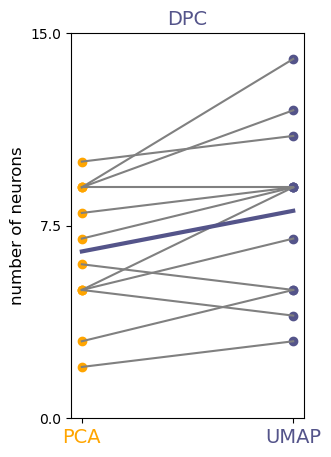

In [240]:
ses_DPC_UMAP = [np.sum(i) for i in neuxsesxelec_DPC]
neuxelec_DPC_PCA = np.array([len(i) for i in classes_per_electrode_DPC])
ses_div = np.cumsum([len(i) for i in neuxsesxelec_DPC])
ses_DPC_PCA = [np.sum(i) for i in np.split(neuxelec_DPC_PCA, ses_div)[:-1]]
colors = ["#FFA500", "#54548A"]
plt.figure(figsize=(3, 5))
for a, b in zip(ses_DPC_PCA, ses_DPC_UMAP):
    plt.plot([0, 1], [a, b], color="gray")
    plt.scatter(0, a, color=colors[0])
    plt.scatter(1, b, color=colors[1])
plt.plot([0, 1], [np.mean(ses_DPC_PCA), np.mean(ses_DPC_UMAP)], color=colors[1], linewidth=3)
plt.title("DPC", color = colors[1], fontsize=14)
texts = plt.xticks([0, 1], ["PCA", "UMAP"], fontsize=14)
for text, color in zip(texts[1], colors):
    text.set_color(color)
    
ymin, ymax = 0, 15
ticks = [ymin, (ymin + ymax) / 2, ymax]
plt.yticks(ticks)
plt.ylim(ymin, ymax)
plt.ylabel("number of neurons", fontsize=12)
#plt.savefig("Neuxses DPC.svg")
plt.show()

In [553]:
num_neu_UMAP_DPC = np.sum(ses_DPC_UMAP)
print(f"There are a total of {num_neu_UMAP_DPC} neurons in DPC sorted with UMAP")

There are a total of 97.0 neurons in DPC sorted with UMAP


In [554]:
num_neu_PCA_DPC = np.sum(ses_DPC_PCA)
print(f"There are a total of {num_neu_PCA_DPC} neurons in DPC sorted with PCA")

There are a total of 78 neurons in DPC sorted with PCA


In [562]:
print(f"There are {len(sesiones_DPC)} DPC sessions")

There are 12 DPC sessions


In [206]:
t_stat, p_value = ttest_rel(ses_DPC_PCA, ses_DPC_UMAP)
print(f"T = {t_stat:.3f}, p = {p_value:.3f}")

T = -2.994, p = 0.012


### Mutual Information (UMAP)

In [232]:
def imxtiempos(tasa, clases, bins=10, tiempo=t):
    #tiempo debería ser una variable con índices
    imxtiempo=np.zeros((len(tiempo)))
    for i, k in enumerate(tiempo):
        y=np.zeros((len(clases), bins))
        tasaxtiempo=tasa[:, k]
        bines=np.histogram_bin_edges(tasaxtiempo, bins=bins, weights=np.ones(len(tasaxtiempo))*1/len(tasaxtiempo))
        bns=np.linspace(min(bines), max(bines), bins)
        yt, xt=np.histogram(tasaxtiempo, bins=bines, weights=np.ones(len(tasaxtiempo))*1/len(tasaxtiempo))
        y[-1]=yt
        for j in range(len(clases)-1):
            txtxc=tasaxtiempo[int(clases[j]):int(clases[j+1])]
            yc, xc=np.histogram(txtxc, bins=bines, weights=np.ones(len(txtxc))*1/len(txtxc))
            y[j]=yc
        imxtiempo[i]=infmutua(y)
    return imxtiempo

In [233]:
tasas_aciertos_DPC = []
clases_aciertos_DPC = []
for i in range(len(tasas_de_disparo_DPC)):
    idx_aciertos = np.where(aciertosxneurona_DPC[i]==1)[0]
    idx_clases = np.argsort(clasesxneurona_DPC[i][idx_aciertos])
    tasas_aciertos_DPC.append(tasas_de_disparo_DPC[i][idx_aciertos][idx_clases])
    clases_aciertos_DPC.append(clasesxneurona_DPC[i][idx_aciertos][idx_clases])

In [234]:
inf_int = np.where((t>=0.25) & (t<=0.5))[0]
infxneu_DPC = np.zeros(len(tasas_de_disparo_DPC))
for i, fr in enumerate(tasas_de_disparo_DPC):
    div_clases = [0]
    idx_sn_tac = np.where(clases_aciertos_DPC[i]>=1)[0]
    idx_tac = np.where(clases_aciertos_DPC[i][idx_sn_tac]<=5)[0]
    tasa_ord = tasas_aciertos_DPC[i][idx_sn_tac]
    div_clases.extend([len(idx_tac), len(idx_sn_tac)])
    infxneu_DPC[i]=np.mean(imxtiempos(tasa_ord, div_clases, tiempo=inf_int))

### Mutual Information (PCA)

In [236]:
inf_int_PCA = np.where((time>=0.25) & (time<=0.5))[0]
infxneu_DPC_PCA = np.zeros(len(tasas_de_disparo_DPC_PCA))
for i, fr in enumerate(tasas_de_disparo_DPC_PCA):
    div_clases = [0]
    idx_sn_tac = np.where(clasesxneurona_DPC_PCA[i]>=1)[0]
    idx_tac = np.where(clasesxneurona_DPC_PCA[i][idx_sn_tac]<=5)[0]
    tasa_ord = tasas_de_disparo_DPC_PCA[i][idx_sn_tac]
    div_clases.extend([len(idx_tac), len(idx_sn_tac)])
    infxneu_DPC_PCA[i]=np.mean(imxtiempos(tasa_ord, div_clases, tiempo=inf_int_PCA))

### UMAP vs PCA

In [237]:
neuxelec_DPC = np.concatenate(neuxsesxelec_DPC)
div_UMAP = np.cumsum(neuxelec_DPC).astype(int)
divinf_UMAP = np.split(infxneu_DPC, div_UMAP)[:-1]
inf_tot_DPC = []
contador = 0
for i in sesiones_DPC:
    sesion = os.path.join(base_DPC, i)
    electrodos = os.listdir(sesion)[:-1]
    for j in electrodos:
        electrodo = os.path.join(sesion, j)
        UMAP_labels = np.loadtxt(os.path.join(electrodo, "sorted_neurons", "sorted_labels.csv"), delimiter=",")
        PCA_labels = np.loadtxt(os.path.join(electrodo, "Sorting PCA", "sorted_labels.csv"), delimiter=",")
        matchesxelectrode = clusters_match(UMAP_labels, PCA_labels)
        for k in matchesxelectrode:
            sum_inf = 0
            for l in k[1]:
                sum_inf+=divinf_UMAP[contador][int(l)]
            inf_tot_DPC.append(sum_inf)
        contador += 1

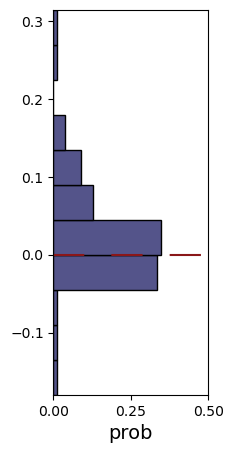

In [518]:
plt.figure(figsize=(2, 5))
data = np.array(inf_tot_DPC)-infxneu_DPC_PCA
ymax = 0.315
ymin = -0.18
bin_width = 0.045
bins_neg = np.arange(0, ymin - bin_width, -bin_width)[::-1]
bins_pos = np.arange(0, ymax + bin_width, bin_width)
bins = np.concatenate((bins_neg, bins_pos))
bins[-1] = ymax
counts, edges = np.histogram(data, bins=bins)
probs = counts / counts.sum()
plt.barh(edges[:-1], probs, height=np.diff(edges), align="edge",
        edgecolor="black", color="#54548A")
plt.xlabel("prob", fontsize=14)
plt.axhline(y = 0, color="#8A1719", linestyle='--', dashes=(15, 13))
xmin, xmax = 0, 0.5
ticks = [xmin, (xmin + xmax) / 2, xmax]
plt.xlim(xmin, xmax)
plt.xticks(ticks)

ymin, ymax = -0.18, 0.315
plt.ylim(ymin, ymax)
#plt.savefig("Dist IM DPC.svg")
plt.show()

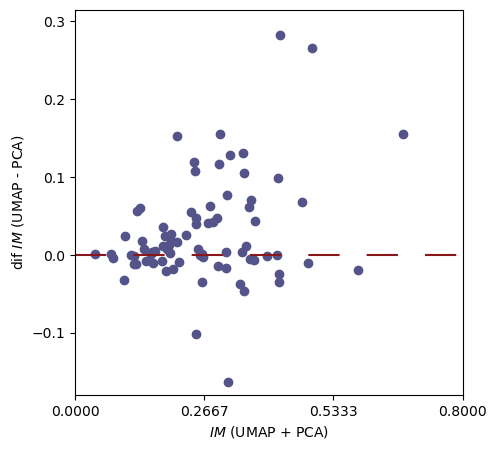

In [519]:
plt.figure(figsize=(5, 5))
plt.scatter(np.array(inf_tot_DPC)+infxneu_DPC_PCA, np.array(inf_tot_DPC)-infxneu_DPC_PCA, color="#54548A")
plt.axhline(y = 0, color="#8A1719", linestyle='--', dashes=(15, 13))
plt.xlabel(r"$IM$ (UMAP + PCA)")
plt.ylabel(r"dif $IM$ (UMAP - PCA)")
ymin, ymax = -0.18, 0.315
plt.ylim(ymin, ymax)
xmin, xmax = 0, 0.8
ticks = np.linspace(xmin, xmax, 4)
plt.xlim(xmin, xmax)
plt.xticks(ticks)
#plt.savefig("IM DPC.svg")
plt.show()

# VPC

### Firing rate (UMAP)

In [535]:
base_VPC = "D:\\Figure 4 Fix\\Processed VPC\\Processed"
sesiones_VPC = os.listdir(os.path.join(procesadas, "Processed VPC", "Processed"))
psico_VPC=[]
clasesxneurona_VPC=[]
aciertosxneurona_VPC=[]
neuronas_VPC=[]
neu_x_sesion_VPC=np.zeros(len(sesiones_VPC)+1)

In [433]:
# Erase this!
base_VPC = "D:\\Figure 4 Fix\\Processed VPC\\Processed" 
for i in sesiones_VPC:
    sesion = os.path.join(base_VPC, i)
    electrodos = os.listdir(sesion)[:-1]
    for j in electrodos:
        electrodo = os.path.join(sesion, j, "Sorting PCA")
        for filename in os.listdir(electrodo):
            file_path = os.path.join(electrodo, filename)
            if os.path.isfile(file_path):
                os.remove(file_path)

In [536]:
nums=[]
nombres_neuronas=[]
neuxsesxelec_VPC = []
for total, i in enumerate(sesiones_VPC): 
    sesion = os.path.join(procesadas, "Processed VPC", "Processed", i)
    electrodos = os.listdir(sesion)[:-1]
    psico=np.loadtxt(os.path.join(sesion, os.listdir(sesion)[-1]), delimiter=",", skiprows=1, usecols=(1, 4, 26))
    psico_VPC.append(psico)
    neu_x_elec = np.zeros(len(electrodos))
    for num_elec, j in enumerate(electrodos):
        electrodo = os.path.join(sesion, j, "sorted_neurons")
        if os.path.exists(electrodo)==True:
            archivos_neuronas = [os.path.basename(f) for f in glob.glob(os.path.join(electrodo, "ne*.csv"))]
            neu_x_elec[num_elec] = len(archivos_neuronas)
            for k in archivos_neuronas:
                conteo_orden=0
                en_es_cl=np.loadtxt(os.path.join(electrodo, k), delimiter=",", skiprows=1)
                ensayos=np.array(np.unique(en_es_cl[:, 0]), dtype=np.int64)
                ensayos_limpios=[]
                clases=np.zeros(len(ensayos))
                aciertos=np.zeros(len(ensayos))
                numero_en=len(ensayos)
                nums.append(numero_en)
                nombres_neuronas.append([electrodo, k])
                for idx, l in enumerate(ensayos):
                    conteo_orden+=1
                    if l==conteo_orden:
                        espigas=en_es_cl[np.where(en_es_cl[:, 0]==l)].T
                        ensayo=espigas[1, :]
                    if len(ensayo)!=0:
                        clases[idx]=psico[l-1, 0]
                        aciertos[idx]=psico[l-1, 1]
                        ensayos_limpios.append(ensayo)
                    else:
                        ensayos_limpios.append(np.array([-7]))
                neuronas_VPC.append(ensayos_limpios)
                clasesxneurona_VPC.append(clases)
                aciertosxneurona_VPC.append(aciertos)
    neu_x_sesion_VPC[total+1]=len(clasesxneurona_VPC)
    neuxsesxelec_VPC.append(neu_x_elec)

In [537]:
tasas_de_disparo_VPC=[]
for i in neuronas_VPC:
    tasa_de_neurona, t=ntdd(i)
    tasas_de_disparo_VPC.append(tasa_de_neurona)

### Firing rate (PCA)

In [ ]:
classes_per_electrode_VPC = []
for i in sesiones_VPC:
    INITIAL_DIRECTORY = os.path.join("D:\\Figure 4 Fix\\Processed VPC\\Processed", i) # Update to your data root
    PSYCHOMETRICS_PATH = os.path.join(INITIAL_DIRECTORY, "psychometrics.csv") # Shared file
    for electrode in os.listdir(INITIAL_DIRECTORY)[:-1]:
        ELECTRODE_FOLDER = os.path.join(INITIAL_DIRECTORY, electrode) # Corrected relative path to electrode folder
        print("--- Running PCA + HDBSCAN sorting for single electrode ---")
        classes_per_neuron = []
        classes_dis = []

        num_neurons, neuron_trial_spikes, psych_df, output_dir = mp.single_electrode_analysis(ELECTRODE_FOLDER, PSYCHOMETRICS_PATH)

        # --- Verificar si el análisis fue exitoso ---
        if output_dir: 
            print("\n--- Results ---")
            print(f"Number of neurons: {num_neurons}")
            print("\nAnalysis complete.")


            # (psych_df ya fue cargado y devuelto por single_electrode_analysis)
            mp.save_sorted_neurons_to_csv(neuron_trial_spikes, psych_df, output_dir)
            names_list = np.zeros(len(neuron_trial_spikes.keys()))

            for idx, neuron_id in enumerate(neuron_trial_spikes.keys()):
                names_list[idx] = neuron_id
                
                # Los IDs de neurona de HDBSCAN empiezan en 0
                neuron_name = f"Neuron_{neuron_id + 1}"

                # Definir save paths
                fr_save_path = os.path.join(output_dir, f"{neuron_name}_FiringRate.png")

                # Llamar a las funciones de ploteo con los save_path
                _, time, classes = mp.average_firing_rate_per_class(neuron_trial_spikes, psych_df, neuron_id, save_path=fr_save_path, get_time=True)
                classes_dis.append(classes)
            print("--- All plots and CSVs saved ---")
            idx_ord = np.argsort(names_list).astype(int)
            for i in idx_ord:
                classes_per_neuron.append(classes_dis[i])
            classes_per_electrode_VPC.append(classes_per_neuron)

        else:
            print("Analysis skipped or failed (e.g., no spikes found).")

In [540]:
clasesxneurona_VPC_PCA = []
for i in classes_per_electrode_VPC:
    for j in i:
        clasesxneurona_VPC_PCA.append(np.concatenate([np.ones(len(sublist))*list(j.keys())[idx] for idx, sublist in enumerate(list(j.values()))]))

In [541]:
tasas_de_disparo_VPC_PCA=[]
for total, i in enumerate(sesiones_VPC): 
    sesion = os.path.join(procesadas, "Processed VPC", "Processed", i)
    electrodos = os.listdir(sesion)[:-1]
    for j in electrodos:
        electrodo = os.path.join(sesion, j, "Sorting PCA")
        if os.path.exists(electrodo)==True:
            archivos_neuronas = [firing_rate for firing_rate in os.listdir(electrodo) if firing_rate[0:2] == "Fr"]
            nombres_ordenados = np.array(sorted(archivos_neuronas, key=lambda x: int(x.split("_")[1].split(".")[0])))
            for k in nombres_ordenados:
                tasas_de_disparo_VPC_PCA.append(np.loadtxt(os.path.join(electrodo, k), delimiter=",", skiprows=1))

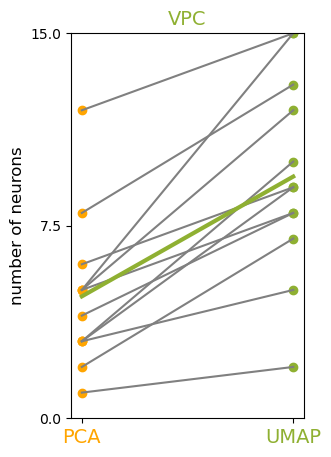

In [542]:
ses_VPC_UMAP = [np.sum(i) for i in neuxsesxelec_VPC]
neuxelec_VPC_PCA = np.array([len(i) for i in classes_per_electrode_VPC])
ses_div = np.cumsum([len(i) for i in neuxsesxelec_VPC])
ses_VPC_PCA = [np.sum(i) for i in np.split(neuxelec_VPC_PCA, ses_div)[:-1]]
colors = ["#FFA500", "#8FB032"]
plt.figure(figsize=(3, 5))
for a, b in zip(ses_VPC_PCA, ses_VPC_UMAP):
    plt.plot([0, 1], [a, b], color="gray")
    plt.scatter(0, a, color=colors[0])
    plt.scatter(1, b, color=colors[1])
plt.plot([0, 1], [np.mean(ses_VPC_PCA), np.mean(ses_VPC_UMAP)], color=colors[1], linewidth=3)
plt.title("VPC", color = colors[1], fontsize=14)
texts = plt.xticks([0, 1], ["PCA", "UMAP"], fontsize=14)
for text, color in zip(texts[1], colors):
    text.set_color(color)

ymin, ymax = 0, 15
ticks = [ymin, (ymin + ymax) / 2, ymax]
plt.yticks(ticks)
plt.ylim(ymin, ymax)
plt.ylabel("number of neurons", fontsize=12)
#plt.savefig("Neuxses VPC.svg")
plt.show()

In [556]:
num_neu_UMAP_VPC = np.sum(ses_VPC_UMAP)
print(f"There are a total of {num_neu_UMAP_VPC} neurons in VPC sorted with UMAP")

There are a total of 113.0 neurons in VPC sorted with UMAP


In [558]:
num_neu_PCA_VPC = np.sum(ses_VPC_PCA)
print(f"There are a total of {num_neu_PCA_VPC} neurons in VPC sorted with PCA")

There are a total of 57 neurons in VPC sorted with PCA


In [561]:
print(f"There are {len(sesiones_VPC)} VPC sessions")

There are 12 VPC sessions


In [442]:
t_stat, p_value = ttest_rel(ses_VPC_PCA, ses_VPC_UMAP)
print(f"T = {t_stat:.3f}, p = {p_value:.3f}")

T = -6.378, p = 0.000


### Mutual Information (UMAP)

In [445]:
neuxses_VPC = np.zeros(len(neuxsesxelec_VPC)+1)
for i in range(len(neuxsesxelec_VPC)):
    neuxses_VPC[i+1]=np.sum(neuxsesxelec_VPC[i])
neuxses_VPC = np.cumsum(neuxses_VPC)

In [446]:
tasas_aciertos_VPC = []
clases_aciertos_VPC = []
for i in range(len(tasas_de_disparo_VPC)):
    try:
        idx_aciertos = np.where(aciertosxneurona_VPC[i]==1)[0]
        idx_clases = np.argsort(clasesxneurona_VPC[i][idx_aciertos])
    except IndexError:
        idx_aciertos_comp = np.where(aciertosxneurona_VPC[i]==1)[0]
        idx_ses = np.searchsorted(neuxses_VPC, i) - 1
        ses = os.path.join(procesadas, "Processed VPC", "Processed", sesiones_VPC[idx_ses])
        psico_temp=np.loadtxt(os.path.join(ses, os.listdir(ses)[-1]), delimiter=",", skiprows=1, usecols=(1))
        missing_indices = indices_extra(clasesxneurona_VPC[i], psico_temp)
        idx_aciertos = ajustar_indices(idx_aciertos_comp, missing_indices)
        idx_clases = np.argsort(clasesxneurona_VPC[i][idx_aciertos])
    tasas_aciertos_VPC.append(tasas_de_disparo_VPC[i][idx_aciertos][idx_clases])
    clases_aciertos_VPC.append(clasesxneurona_VPC[i][idx_aciertos][idx_clases])

In [447]:
infxneu_VPC = np.zeros(len(tasas_de_disparo_VPC))
for i, fr in enumerate(tasas_de_disparo_VPC):
    div_clases = [0]
    idx_sn_tac = np.where(clases_aciertos_VPC[i]>=1)[0]
    idx_tac = np.where(clases_aciertos_VPC[i][idx_sn_tac]<=5)[0]
    tasa_ord = tasas_aciertos_VPC[i][idx_sn_tac]
    div_clases.extend([len(idx_tac), len(idx_sn_tac)])
    infxneu_VPC[i]=np.mean(imxtiempos(tasa_ord, div_clases, tiempo=inf_int))

### Mutual Information (PCA)

In [448]:
infxneu_VPC_PCA = np.zeros(len(tasas_de_disparo_VPC_PCA))
for i, fr in enumerate(tasas_de_disparo_VPC_PCA):
    div_clases = [0]
    idx_sn_tac = np.where(clasesxneurona_VPC_PCA[i]>=1)[0]
    idx_tac = np.where(clasesxneurona_VPC_PCA[i][idx_sn_tac]<=5)[0]
    tasa_ord = tasas_de_disparo_VPC_PCA[i][idx_sn_tac]
    div_clases.extend([len(idx_tac), len(idx_sn_tac)])
    infxneu_VPC_PCA[i]=np.mean(imxtiempos(tasa_ord, div_clases, tiempo=inf_int_PCA))

### UMAP vs PCA

In [449]:
neuxelec_VPC = np.concatenate(neuxsesxelec_VPC)
div_UMAP = np.cumsum(neuxelec_VPC).astype(int)
divinf_UMAP = np.split(infxneu_VPC, div_UMAP)[:-1]
inf_tot_VPC = []
contador = 0
for i in sesiones_VPC:
    sesion = os.path.join(base_VPC, i)
    electrodos = os.listdir(sesion)[:-1]
    for j in electrodos:
        electrodo = os.path.join(sesion, j)
        try:
            UMAP_labels = np.loadtxt(os.path.join(electrodo, "sorted_neurons", "sorted_labels.csv"), delimiter=",")
            PCA_labels = np.loadtxt(os.path.join(electrodo, "Sorting PCA", "sorted_labels.csv"), delimiter=",")
            matchesxelectrode = clusters_match(UMAP_labels, PCA_labels)
            for k in matchesxelectrode:
                sum_inf = 0
                for l in k[1]:
                    sum_inf+=divinf_UMAP[contador][int(l)]
                inf_tot_VPC.append(sum_inf)
            contador += 1
        except FileNotFoundError:
            contador += 1

In [478]:
minus = np.array(inf_tot_VPC)-infxneu_VPC_PCA
plus = np.array(inf_tot_VPC)+infxneu_VPC_PCA
outlier = np.where(minus > 1)[0]
minus[outlier] = 0.58
plus[outlier] = 1.9

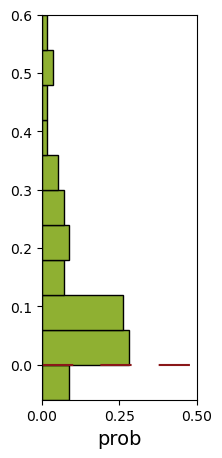

In [521]:
plt.figure(figsize=(2, 5))
data = minus
ymax = 0.6
ymin = -0.06
bin_width = 0.06
bins_neg = np.arange(0, ymin - bin_width, -bin_width)[::-1]
bins_pos = np.arange(0, ymax + bin_width, bin_width)
bins = np.concatenate((bins_neg, bins_pos))
bins[-1] = ymax
counts, edges = np.histogram(data, bins=bins)
probs = counts / counts.sum()
plt.barh(edges[:-1], probs, height=np.diff(edges), align="edge",
        edgecolor="black", color="#8FB032")
plt.xlabel("prob", fontsize=14)
plt.axhline(y = 0, color="#8A1719", linestyle='--', dashes=(15, 13))
xmin, xmax = 0, 0.5
ticks = [xmin, (xmin + xmax) / 2, xmax]
plt.xlim(xmin, xmax)
plt.xticks(ticks)

ymin, ymax = -0.06, 0.6
plt.ylim(ymin, ymax)
#plt.savefig("Dist IM VPC.svg")
plt.show()

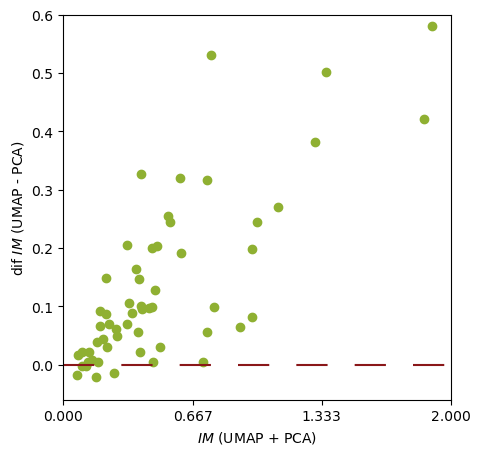

In [513]:
plt.figure(figsize=(5, 5))
plt.scatter(plus, minus, color="#8FB032")
plt.axhline(y = 0, color="#8A1719", linestyle='--', dashes=(15, 13))
plt.xlabel(r"$IM$ (UMAP + PCA)")
plt.ylabel(r"dif $IM$ (UMAP - PCA)")
ymin, ymax = -0.06, 0.6
plt.ylim(ymin, ymax)
xmin, xmax = 0, 2
ticks = np.linspace(xmin, xmax, 4)
plt.xlim(xmin, xmax)
plt.xticks(ticks)
#plt.savefig("IM VPC.svg")
plt.show()

# S2

### Processed 2

### Firing rate (UMAP)

In [75]:
base_26 = "D:\\Figure 4 Fix\\Processed S2\\Processed 2" 
sesiones_26 = os.listdir(os.path.join(procesadas, "Procesados S2", "Processed 2"))
psico_26=[]
clasesxneurona_26=[]
aciertosxneurona_26=[]
neuronas_26=[]
neu_x_sesion_26=np.zeros(len(sesiones_26)+1)

In [394]:
# Erase this!
base_26 = "D:\\Figure 4 Fix\\Processed S2\\Processed 2" 
for i in sesiones_26:
    sesion = os.path.join(base_26, i)
    electrodos = os.listdir(sesion)[:-1]
    for j in electrodos:
        electrodo = os.path.join(sesion, j, "Sorting PCA")
        for filename in os.listdir(electrodo):
            file_path = os.path.join(electrodo, filename)
            if os.path.isfile(file_path):
                os.remove(file_path)

In [76]:
nums=[]
nombres_neuronas=[]
neuxsesxelec_26 = []
for total, i in enumerate(sesiones_26): 
    sesion = os.path.join(procesadas, "Processed S2", "Processed 2", i)
    electrodos = os.listdir(sesion)[:-1]
    psico=np.loadtxt(os.path.join(sesion, os.listdir(sesion)[-1]), delimiter=",", skiprows=1, usecols=(1, 4, 24))
    psico_26.append(psico)
    neu_x_elec = np.zeros(len(electrodos))
    for num_elec, j in enumerate(electrodos):
        electrodo = os.path.join(sesion, j, "sorted_neurons")
        if os.path.exists(electrodo)==True:
            archivos_neuronas = [os.path.basename(f) for f in glob.glob(os.path.join(electrodo, "ne*.csv"))]
            neu_x_elec[num_elec] = len(archivos_neuronas)
            for k in archivos_neuronas:
                conteo_orden=0
                en_es_cl=np.loadtxt(os.path.join(electrodo, k), delimiter=",", skiprows=1)
                ensayos=np.array(np.unique(en_es_cl[:, 0]), dtype=np.int64)
                ensayos_limpios=[]
                clases=np.zeros(len(ensayos))
                aciertos=np.zeros(len(ensayos))
                numero_en=len(ensayos)
                nums.append(numero_en)
                nombres_neuronas.append([electrodo, k])
                for idx, l in enumerate(ensayos):
                    conteo_orden+=1
                    if l==conteo_orden:
                        espigas=en_es_cl[np.where(en_es_cl[:, 0]==l)].T
                        ensayo=espigas[1, :]
                    if len(ensayo)!=0:
                        clases[idx]=psico[l-1, 0]
                        aciertos[idx]=psico[l-1, 1]
                        ensayos_limpios.append(ensayo+0.1) #We subtract 0.1 because the alignment of these trials at the start of the stimulus is different from RR032
                    else:
                        ensayos_limpios.append(np.array([-7]))
                neuronas_26.append(ensayos_limpios)
                clasesxneurona_26.append(clases)
                aciertosxneurona_26.append(aciertos)
    neu_x_sesion_26[total+1]=len(clasesxneurona_26)
    neuxsesxelec_26.append(neu_x_elec)

In [77]:
tasas_de_disparo_26=[]
for i in neuronas_26:
    tasa_de_neurona, t=ntdd(i)
    tasas_de_disparo_26.append(tasa_de_neurona)

### Firing rate (PCA)

In [ ]:
classes_per_electrode_26 = []
for i in sesiones_26:
    INITIAL_DIRECTORY = os.path.join("D:\\Figure 4 Fix\\Processed S2\\Processed 2", i) # Update to your data root
    PSYCHOMETRICS_PATH = os.path.join(INITIAL_DIRECTORY, "psychometrics.csv") # Shared file
    for electrode in os.listdir(INITIAL_DIRECTORY)[:-1]:
        ELECTRODE_FOLDER = os.path.join(INITIAL_DIRECTORY, electrode) # Corrected relative path to electrode folder
        print("--- Running PCA + HDBSCAN sorting for single electrode ---")
        classes_per_neuron = []
        classes_dis = []

        num_neurons, neuron_trial_spikes, psych_df, output_dir = mp.single_electrode_analysis(ELECTRODE_FOLDER, PSYCHOMETRICS_PATH)

        # --- Verificar si el análisis fue exitoso ---
        if output_dir: 
            print("\n--- Results ---")
            print(f"Number of neurons: {num_neurons}")
            print("\nAnalysis complete.")


            # (psych_df ya fue cargado y devuelto por single_electrode_analysis)
            mp.save_sorted_neurons_to_csv(neuron_trial_spikes, psych_df, output_dir)
            names_list = np.zeros(len(neuron_trial_spikes.keys()))

            for idx, neuron_id in enumerate(neuron_trial_spikes.keys()):
                names_list[idx] = neuron_id
                
                # Los IDs de neurona de HDBSCAN empiezan en 0
                neuron_name = f"Neuron_{neuron_id + 1}"

                # Definir save paths
                fr_save_path = os.path.join(output_dir, f"{neuron_name}_FiringRate.png")

                # Llamar a las funciones de ploteo con los save_path
                _, time, classes = mp.average_firing_rate_per_class(neuron_trial_spikes, psych_df, neuron_id, save_path=fr_save_path, get_time=True)
                classes_dis.append(classes)
            print("--- All plots and CSVs saved ---")
            idx_ord = np.argsort(names_list).astype(int)
            for i in idx_ord:
                classes_per_neuron.append(classes_dis[i])
            classes_per_electrode_26.append(classes_per_neuron)

        else:
            print("Analysis skipped or failed (e.g., no spikes found).")

In [81]:
clasesxneurona_26_PCA = []
for i in classes_per_electrode_26:
    for j in i:
        clasesxneurona_26_PCA.append(np.concatenate([np.ones(len(sublist))*list(j.keys())[idx] for idx, sublist in enumerate(list(j.values()))]))

In [82]:
tasas_de_disparo_26_PCA=[]
for total, i in enumerate(sesiones_26): 
    sesion = os.path.join(procesadas, "Processed S2", "Processed 2", i)
    electrodos = os.listdir(sesion)[:-1]
    for j in electrodos:
        electrodo = os.path.join(sesion, j, "Sorting PCA")
        if os.path.exists(electrodo)==True:
            archivos_neuronas = [firing_rate for firing_rate in os.listdir(electrodo) if firing_rate[0:2] == "Fr"]
            nombres_ordenados = np.array(sorted(archivos_neuronas, key=lambda x: int(x.split("_")[1].split(".")[0])))
            for k in nombres_ordenados:
                tasas_de_disparo_26_PCA.append(np.loadtxt(os.path.join(electrodo, k), delimiter=",", skiprows=1))

### Processed 1

### Firing rate (UMAP)

In [83]:
base_S2 = "D:\\Figure 4 Fix\\Processed S2\\Processed 1" 
sesiones_S2 = os.listdir(os.path.join(procesadas, "Processed S2", "Processed 1"))
psico_S2=[]
clasesxneurona_S2=[]
aciertosxneurona_S2=[]
neuronas_S2=[]
neu_x_sesion_S2=np.zeros(len(sesiones_S2)+1)

In [326]:
# Erase this!
base_S2 = "D:\\Figure 4\\Processed S2\\Processed 1" 
for i in sesiones_S2:
    sesion = os.path.join(base_S2, i)
    electrodos = os.listdir(sesion)[:-1]
    for j in electrodos:
        electrodo = os.path.join(sesion, j, "Sorting PCA")
        for filename in os.listdir(electrodo):
            file_path = os.path.join(electrodo, filename)
            if os.path.isfile(file_path):
                os.remove(file_path)

In [84]:
nums=[]
nombres_neuronas=[]
neuxsesxelec_S2 = []
for total, i in enumerate(sesiones_S2): 
    sesion = os.path.join(procesadas, "Processed S2", "Processed 1", i)
    electrodos = os.listdir(sesion)[:-1]
    psico=np.loadtxt(os.path.join(sesion, os.listdir(sesion)[-1]), delimiter=",", skiprows=1, usecols=(1, 4, 26))
    psico_S2.append(psico)
    neu_x_elec = np.zeros(len(electrodos))
    for num_elec, j in enumerate(electrodos):
        electrodo = os.path.join(sesion, j, "sorted_neurons")
        if os.path.exists(electrodo)==True:
            archivos_neuronas = [os.path.basename(f) for f in glob.glob(os.path.join(electrodo, "ne*.csv"))]
            neu_x_elec[num_elec] = len(archivos_neuronas)
            for k in archivos_neuronas:
                conteo_orden=0
                en_es_cl=np.loadtxt(os.path.join(electrodo, k), delimiter=",", skiprows=1)
                ensayos=np.array(np.unique(en_es_cl[:, 0]), dtype=np.int64)
                ensayos_limpios=[]
                clases=np.zeros(len(ensayos))
                aciertos=np.zeros(len(ensayos))
                numero_en=len(ensayos)
                nums.append(numero_en)
                nombres_neuronas.append([electrodo, k])
                for idx, l in enumerate(ensayos):
                    conteo_orden+=1
                    if l==conteo_orden:
                        espigas=en_es_cl[np.where(en_es_cl[:, 0]==l)].T
                        ensayo=espigas[1, :]
                    if len(ensayo)!=0:
                        clases[idx]=psico[l-1, 0]
                        aciertos[idx]=psico[l-1, 1]
                        ensayos_limpios.append(ensayo)
                    else:
                        ensayos_limpios.append(np.array([-7]))
                neuronas_S2.append(ensayos_limpios)
                clasesxneurona_S2.append(clases)
                aciertosxneurona_S2.append(aciertos)
    neu_x_sesion_S2[total+1]=len(clasesxneurona_S2)
    neuxsesxelec_S2.append(neu_x_elec)

In [85]:
tasas_de_disparo_S2=[]
for i in neuronas_S2:
    tasa_de_neurona, t=ntdd(i)
    tasas_de_disparo_S2.append(tasa_de_neurona)

In [86]:
medias_S2_UMAP = np.zeros(len(tasas_de_disparo_S2))

In [87]:
for i in range(len(tasas_de_disparo_S2)):
    neurona = tasas_de_disparo_S2[i][:, intervalo]
    medias_S2_UMAP[i] = np.mean(neurona)

### Firing rate (PCA)

In [ ]:
classes_per_electrode_S2 = []
for i in sesiones_S2:
    INITIAL_DIRECTORY = os.path.join("D:\\Figure 4 Fix\\Processed S2\\Processed 1", i) # Update to your data root
    PSYCHOMETRICS_PATH = os.path.join(INITIAL_DIRECTORY, "psychometrics.csv") # Shared file
    for electrode in os.listdir(INITIAL_DIRECTORY)[:-1]:
        ELECTRODE_FOLDER = os.path.join(INITIAL_DIRECTORY, electrode) # Corrected relative path to electrode folder
        print("--- Running PCA + HDBSCAN sorting for single electrode ---")
        classes_per_neuron = []
        classes_dis = []

        num_neurons, neuron_trial_spikes, psych_df, output_dir = mp.single_electrode_analysis(ELECTRODE_FOLDER, PSYCHOMETRICS_PATH)

        # --- Verificar si el análisis fue exitoso ---
        if output_dir: 
            print("\n--- Results ---")
            print(f"Number of neurons: {num_neurons}")
            print("\nAnalysis complete.")


            # (psych_df ya fue cargado y devuelto por single_electrode_analysis)
            mp.save_sorted_neurons_to_csv(neuron_trial_spikes, psych_df, output_dir)
            names_list = np.zeros(len(neuron_trial_spikes.keys()))

            for idx, neuron_id in enumerate(neuron_trial_spikes.keys()):
                names_list[idx] = neuron_id
                
                # Los IDs de neurona de HDBSCAN empiezan en 0
                neuron_name = f"Neuron_{neuron_id + 1}"

                # Definir save paths
                fr_save_path = os.path.join(output_dir, f"{neuron_name}_FiringRate.png")

                # Llamar a las funciones de ploteo con los save_path
                _, time, classes = mp.average_firing_rate_per_class(neuron_trial_spikes, psych_df, neuron_id, save_path=fr_save_path, get_time=True)
                classes_dis.append(classes)
            print("--- All plots and CSVs saved ---")
            idx_ord = np.argsort(names_list).astype(int)
            for i in idx_ord:
                classes_per_neuron.append(classes_dis[i])
            classes_per_electrode_S2.append(classes_per_neuron)

        else:
            print("Analysis skipped or failed (e.g., no spikes found).")

In [89]:
clasesxneurona_S2_PCA = []
for i in classes_per_electrode_S2:
    for j in i:
        clasesxneurona_S2_PCA.append(np.concatenate([np.ones(len(sublist))*list(j.keys())[idx] for idx, sublist in enumerate(list(j.values()))]))

In [90]:
tasas_de_disparo_S2_PCA=[]
for total, i in enumerate(sesiones_S2): 
    sesion = os.path.join(procesadas, "Processed S2", "Processed 1", i)
    electrodos = os.listdir(sesion)[:-1]
    for j in electrodos:
        electrodo = os.path.join(sesion, j, "Sorting PCA")
        if os.path.exists(electrodo)==True:
            archivos_neuronas = [firing_rate for firing_rate in os.listdir(electrodo) if firing_rate[0:2] == "Fr"]
            nombres_ordenados = np.array(sorted(archivos_neuronas, key=lambda x: int(x.split("_")[1].split(".")[0])))
            for k in nombres_ordenados:
                tasas_de_disparo_S2_PCA.append(np.loadtxt(os.path.join(electrodo, k), delimiter=",", skiprows=1))

In [91]:
neuxsesxelec_S2 = neuxsesxelec_S2 + neuxsesxelec_26

In [92]:
classes_per_electrode_S2 = classes_per_electrode_S2 + classes_per_electrode_26

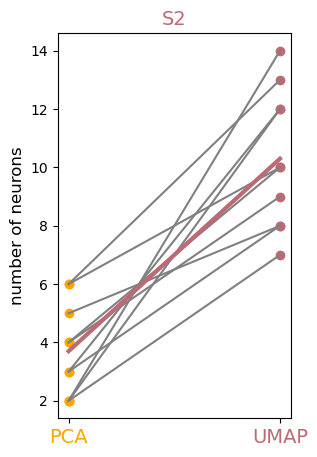

In [121]:
ses_S2_UMAP = [np.sum(i) for i in neuxsesxelec_S2]
neuxelec_S2_PCA = np.array([len(i) for i in classes_per_electrode_S2])
ses_div = np.cumsum([len(i) for i in neuxsesxelec_S2])
ses_S2_PCA = [np.sum(i) for i in np.split(neuxelec_S2_PCA, ses_div)[:-1]]
colors = ["#FFA500", "#BD6A74"]
plt.figure(figsize=(3, 5))
for a, b in zip(ses_S2_PCA, ses_S2_UMAP):
    plt.plot([0, 1], [a, b], color="gray")
    plt.scatter(0, a, color=colors[0])
    plt.scatter(1, b, color=colors[1])
plt.plot([0, 1], [np.mean(ses_S2_PCA), np.mean(ses_S2_UMAP)], color=colors[1], linewidth=3)
plt.title("S2", color = colors[1], fontsize=14)
texts = plt.xticks([0, 1], ["PCA", "UMAP"], fontsize=14)
for text, color in zip(texts[1], colors):
    text.set_color(color)

ymin, ymax = 0, 15
ticks = [ymin, (ymin + ymax) / 2, ymax]
plt.yticks(ticks)
plt.ylim(ymin, ymax)
plt.ylabel("number of neurons", fontsize=12)
#plt.savefig("Neuxses S2.svg")
plt.show()

In [550]:
num_neu_UMAP_S2 = np.sum(ses_S2_UMAP)
print(f"There are a total of {num_neu_UMAP_S2} neurons in S2 sorted with UMAP")

There are a total of 103.0 neurons in S2 sorted with UMAP


In [551]:
num_neu_PCA_S2 = np.sum(ses_S2_PCA)
print(f"There are a total of {num_neu_PCA_S2} neurons in S2 sorted with PCA")

There are a total of 37 neurons in S2 sorted with PCA


In [564]:
print(f"There are {len(sesiones_S2) + len(sesiones_26)} S2 sessions")

There are 10 S2 sessions


In [94]:
t_stat, p_value = ttest_rel(ses_S2_PCA, ses_S2_UMAP)
print(f"T = {t_stat:.3f}, p = {p_value:.3f}")

T = -7.259, p = 0.000


### Mutual Information (UMAP, Processed 2)

In [97]:
neuxses_26 = np.zeros(len(neuxsesxelec_26)+1)
for i in range(len(neuxsesxelec_26)):
    neuxses_26[i+1]=np.sum(neuxsesxelec_26[i])
neuxses_26 = np.cumsum(neuxses_26)

In [98]:
tasas_aciertos_26 = []
clases_aciertos_26 = []
for i in range(len(tasas_de_disparo_26)):
    try:
        idx_aciertos = np.where(aciertosxneurona_26[i]==1)[0]
        idx_clases = np.argsort(clasesxneurona_26[i][idx_aciertos])
    except IndexError:
        idx_aciertos_comp = np.where(aciertosxneurona_26[i]==1)[0]
        idx_ses = np.searchsorted(neuxses_26, i) - 1
        ses = os.path.join(procesadas, "Processed S2", "Processed 2", sesiones_26[idx_ses])
        psico_temp=np.loadtxt(os.path.join(ses, os.listdir(ses)[-1]), delimiter=",", skiprows=1, usecols=(1))
        missing_indices = indices_extra(clasesxneurona_26[i], psico_temp)
        idx_aciertos = ajustar_indices(idx_aciertos_comp, missing_indices)
        idx_clases = np.argsort(clasesxneurona_26[i][idx_aciertos])
    tasas_aciertos_26.append(tasas_de_disparo_26[i][idx_aciertos][idx_clases])
    clases_aciertos_26.append(clasesxneurona_26[i][idx_aciertos][idx_clases])

In [99]:
infxneu_26 = np.zeros(len(tasas_de_disparo_26))
for i, fr in enumerate(tasas_de_disparo_26):
    div_clases = [0]
    idx_sn_tac = np.where(clases_aciertos_26[i]>=1)[0]
    idx_tac = np.where(clases_aciertos_26[i][idx_sn_tac]<=6)[0]
    tasa_ord = tasas_aciertos_26[i][idx_sn_tac]
    div_clases.extend([len(idx_tac), len(idx_sn_tac)])
    infxneu_26[i]=np.mean(imxtiempos(tasa_ord, div_clases, tiempo=inf_int))

### Mutual Information (UMAP, Processed 1)

In [100]:
neuxses_S2 = np.zeros(len(neuxsesxelec_S2)+1)
for i in range(len(neuxsesxelec_S2)):
    neuxses_S2[i+1]=np.sum(neuxsesxelec_S2[i])
neuxses_S2 = np.cumsum(neuxses_S2)

In [101]:
tasas_aciertos_S2 = []
clases_aciertos_S2 = []
for i in range(len(tasas_de_disparo_S2)):
    try:
        idx_aciertos = np.where(aciertosxneurona_S2[i]==1)[0]
        idx_clases = np.argsort(clasesxneurona_S2[i][idx_aciertos])
    except IndexError:
        idx_aciertos_comp = np.where(aciertosxneurona_S2[i]==1)[0]
        idx_ses = np.searchsorted(neuxses_S2, i) - 1
        ses = os.path.join(procesadas, "Processed S2", "Processed 1", sesiones_S2[idx_ses])
        psico_temp=np.loadtxt(os.path.join(ses, os.listdir(ses)[-1]), delimiter=",", skiprows=1, usecols=(1))
        missing_indices = indices_extra(clasesxneurona_S2[i], psico_temp)
        idx_aciertos = ajustar_indices(idx_aciertos_comp, missing_indices)
        idx_clases = np.argsort(clasesxneurona_S2[i][idx_aciertos])
    tasas_aciertos_S2.append(tasas_de_disparo_S2[i][idx_aciertos][idx_clases])
    clases_aciertos_S2.append(clasesxneurona_S2[i][idx_aciertos][idx_clases])

In [102]:
infxneu_S2 = np.zeros(len(tasas_de_disparo_S2))
for i, fr in enumerate(tasas_de_disparo_S2):
    div_clases = [0]
    idx_sn_tac = np.where(clases_aciertos_S2[i]>=1)[0]
    idx_tac = np.where(clases_aciertos_S2[i][idx_sn_tac]<=5)[0]
    tasa_ord = tasas_aciertos_S2[i][idx_sn_tac]
    div_clases.extend([len(idx_tac), len(idx_sn_tac)])
    infxneu_S2[i]=np.mean(imxtiempos(tasa_ord, div_clases, tiempo=inf_int))

In [103]:
infxneu_S2 = np.concatenate((infxneu_S2, infxneu_26))

### Mutual Information (PCA, Processed 2)

In [104]:
infxneu_26_PCA = np.zeros(len(tasas_de_disparo_26_PCA))
for i, fr in enumerate(tasas_de_disparo_26_PCA):
    div_clases = [0]
    idx_sn_tac = np.where(clasesxneurona_26_PCA[i]>=1)[0]
    idx_tac = np.where(clasesxneurona_26_PCA[i][idx_sn_tac]<=6)[0]
    tasa_ord = tasas_de_disparo_26_PCA[i][idx_sn_tac]
    div_clases.extend([len(idx_tac), len(idx_sn_tac)])
    infxneu_26_PCA[i]=np.mean(imxtiempos(tasa_ord, div_clases, tiempo=inf_int_PCA))

### Mutual Information (PCA, Processed 1)

In [105]:
infxneu_S2_PCA = np.zeros(len(tasas_de_disparo_S2_PCA))
for i, fr in enumerate(tasas_de_disparo_S2_PCA):
    div_clases = [0]
    idx_sn_tac = np.where(clasesxneurona_S2_PCA[i]>=1)[0]
    idx_tac = np.where(clasesxneurona_S2_PCA[i][idx_sn_tac]<=5)[0]
    tasa_ord = tasas_de_disparo_S2_PCA[i][idx_sn_tac]
    div_clases.extend([len(idx_tac), len(idx_sn_tac)])
    infxneu_S2_PCA[i]=np.mean(imxtiempos(tasa_ord, div_clases, tiempo=inf_int_PCA))

In [106]:
infxneu_S2_PCA = np.concatenate((infxneu_S2_PCA, infxneu_26_PCA))

### UMAP vs PCA

In [107]:
neuxelec_S2 = np.concatenate(neuxsesxelec_S2)
div_UMAP = np.cumsum(neuxelec_S2).astype(int)
divinf_UMAP = np.split(infxneu_S2, div_UMAP)[:-1]
inf_tot_S2 = []
contador = 0
for i in sesiones_S2:
    sesion = os.path.join(base_S2, i)
    electrodos = os.listdir(sesion)[:-1]
    for j in electrodos:
        electrodo = os.path.join(sesion, j)
        UMAP_labels = np.loadtxt(os.path.join(electrodo, "sorted_neurons", "sorted_labels.csv"), delimiter=",")
        PCA_labels = np.loadtxt(os.path.join(electrodo, "Sorting PCA", "sorted_labels.csv"), delimiter=",")
        matchesxelectrode = clusters_match(UMAP_labels, PCA_labels)
        for k in matchesxelectrode:
            sum_inf = 0
            for l in k[1]:
                sum_inf+=divinf_UMAP[contador][int(l)]
            inf_tot_S2.append(sum_inf)
        contador += 1

In [108]:
for i in sesiones_26:
    sesion = os.path.join(base_26, i)
    electrodos = os.listdir(sesion)[:-1]
    for j in electrodos:
        electrodo = os.path.join(sesion, j)
        UMAP_labels = np.loadtxt(os.path.join(electrodo, "sorted_neurons", "sorted_labels.csv"), delimiter=",")
        PCA_labels = np.loadtxt(os.path.join(electrodo, "Sorting PCA", "sorted_labels.csv"), delimiter=",")
        matchesxelectrode = clusters_match(UMAP_labels, PCA_labels)
        for k in matchesxelectrode:
            sum_inf = 0
            for l in k[1]:
                sum_inf+=divinf_UMAP[contador][int(l)]
            inf_tot_S2.append(sum_inf)
        contador += 1

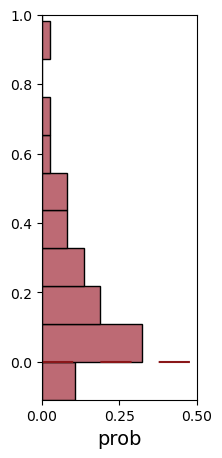

In [149]:
plt.figure(figsize=(2, 5))
n_bins=9
x = np.array(inf_tot_S2)-infxneu_S2_PCA
bin_width = (x.max() - x.min()) / n_bins
x_min = np.floor(x.min() / bin_width) * bin_width
x_max = np.ceil(x.max() / bin_width) * bin_width
bins = np.arange(x_min, x_max + bin_width, bin_width)
if 0 not in bins:
    bins = np.sort(np.append(bins, 0))
counts, bins = np.histogram(x, bins=bins)
probs = counts / counts.sum()
bin_centers = 0.5 * (bins[:-1] + bins[1:])
plt.barh(bin_centers, probs, height=(bins[1]-bins[0]), color="#BD6A74", edgecolor="black")
plt.axhline(y = 0, color="#8A1719", linestyle='--', dashes=(15, 13))
plt.xlabel("prob", fontsize=14)

xmin, xmax = 0, 0.5
ticks = [xmin, (xmin + xmax) / 2, xmax]
plt.xlim(xmin, xmax)
plt.xticks(ticks)

ymin, ymax = bins.min(), 1
plt.ylim(ymin, ymax)

#plt.savefig("Dist IM S2.svg")
plt.show()

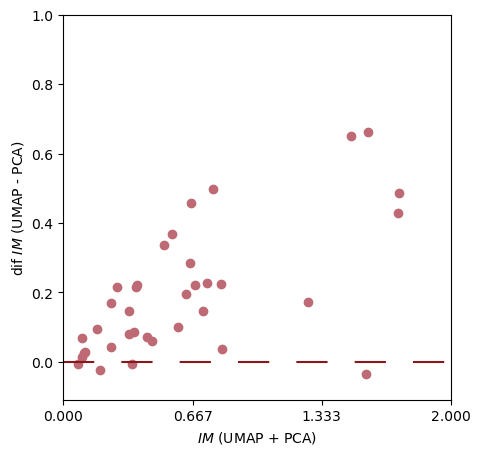

In [154]:
plt.figure(figsize=(5, 5))
plt.scatter(np.array(inf_tot_S2)+infxneu_S2_PCA, np.array(inf_tot_S2)-infxneu_S2_PCA, color="#BD6A74")
plt.axhline(y = 0, color="#8A1719", linestyle='--', dashes=(15, 13))
plt.xlabel(r"$IM$ (UMAP + PCA)")
plt.ylabel(r"dif $IM$ (UMAP - PCA)")
ymin, ymax = bins.min(), 1
plt.ylim(ymin, ymax)
xmin, xmax = 0, 2
ticks = np.linspace(xmin, xmax, 4)
plt.xlim(xmin, xmax)
plt.xticks(ticks)
#plt.savefig("IM S2.svg")
plt.show()